# Signal tracking with RNNs

This notebook simulates time-varying sinosidal signal tracking with Recurrent Neural networks. An artificial multicomponent sinusoidal signal is tracked by an LSTM network. The LSTM network takes a data point and using this data and the information in its memory predicts the next data point. If the predicted data point is close enough to original one, we drive the network in tracking mode(No update for parameters). If this is not the case, the network is trained with these new data points.

Notebook consists of four main blocks:

__1.Generating signal:__ A signal of length 1000 sec is generated as sum of two sine signals which have different phases and frequencies.
Then, other sine signals are added in time. 
In this specific example two signals added. 1st one arises on 150th sec and grows until 250th sec, then second appears on 350th sec and its development ends at 400th sec. (2nd cell)

__2.Creating the LSTM network__: A multilayer, multiunit architecture is created.(One can skim [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) link for a brief introduction to LSTMs.) However, in simulations only 1-layer architecture is devised. (4th cell)

__3.Definition of loss and creating training optimizers__: To train the network created above, Adam optimizer is used. The mean squared error is used for the loss, because we want to track the signal, and it is a regression problem. In general, mean squared error or mean absolute error is used for regression tasks. But mean absolute error may create several problems for the convergence of the optimizers. Therefore, we device the mean squared error.

__4.Signal Tracking:__ The generated signal is tracked via an LSTM network. LSTM network takes the input at time t and predicts the data at time t+1 using this input and information in its memory. Then, the loss is computed for a window if it is below a certain threshold (this will be called as tracking error threshold), the network takes the next input, and this goes on until the error exceeds this threshold. If the loss is above tracking threshold, the system activates training. Adam optimizer updates are applied to network's parameters until it catches the signal, i.e. the error for the window goes down below another threshold (this is named as training threshold) which is smaller than tracking threshold. Because we do not want to change modes between training and tracking at borders. 

One can review the code with comments.

__Results:__ The aim of this framework is basically "to show that RNN network can recognize the changes in the sinusoidal signals, and easily adapt their parameters accordingly".
The modes of network during the tracking task of the signal mentioned above can be seen below. The starting points of arising signals and the end points of their progresses are also marked.
<img src='unknown.png'>

In [1]:
#import packages
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#data generation
def generate_data():
    t_end=1000#final time for signal
    t_fs=[150,350]#where the fault signal appears first
    t_fe=[200,450]#where the progress of fault signal finishes
    
    fs=2000#sampling frequency
    t=np.arange(0,t_end+1/fs,1/fs)
    signal=np.zeros(t.shape)
    f_healthy=[50,125]#baseline sine frequencies- these freqs are present for all time
    f_faulty=[100,300]#fault sine frequencies - these freqs occur in time
    #baseline signal
    for f in f_healthy:
        signal=signal+0.333*np.cos(2*np.pi*f*t+np.random.rand())
    #fault signal
    for i,f in enumerate(f_faulty):
        signal=signal+0.333*(1/(1+np.exp(((t_fs[i]+t_fe[i])/2-t)*(10/(t_fe[i]-t_fs[i])))))*np.cos(2*np.pi*f*t+np.random.rand())
    x=signal[:-1]
    y=signal[1:]
    return x,y,t[:-1]

In [3]:
#plots
def plot(t,predictions_series,output_y):
    plt.figure()
    plt.plot(t,predictions_series,color="red")
    plt.plot(t,output_y,color="green")
    plt.pause(0.001)

In [4]:
##beginning of the network code
#LSTM network:
truncated_bp_length=100#unroll parameter for training
state_size=8#number of states(both hidden neurons and cell states) in LSTM cell
num_of_layers=1#number of LSTM layers

In [5]:
input_x=tf.placeholder(tf.float32,[1,truncated_bp_length])#input placeholder
output_y=tf.placeholder(tf.float32,[1,truncated_bp_length])#output placeholder(for training and tracking error check)
init_state=tf.placeholder(tf.float32,[num_of_layers,2,1,state_size])#initial state placeholder for lstm
                                                                  #(2 stands for hidden and cell state)

In [9]:
print(type(input_x), input_x.shape)
print(type(output_y), output_y.shape)
print(type(init_state), init_state.shape)

<class 'tensorflow.python.framework.ops.Tensor'> (1, 100)
<class 'tensorflow.python.framework.ops.Tensor'> (1, 100)
<class 'tensorflow.python.framework.ops.Tensor'> (1, 2, 1, 8)


In [10]:
state_dict=tf.unstack(init_state,axis=0)
init_state_rnn_tuple=tuple([tf.nn.rnn_cell.LSTMStateTuple(state_dict[idx][0],state_dict[idx][1]) 
                            for idx in range(num_of_layers)])#initial state tuple (rnn network accept initial state
                                                             # in this format)

In [13]:
print(type(state_dict))
print(type(init_state_rnn_tuple))

<class 'list'>
<class 'tuple'>


In [15]:
#single lstm cell
def lstm_cell():
    lstm_unit=tf.nn.rnn_cell.BasicLSTMCell(state_size,state_is_tuple=True)#dropout can be added after this line
    return lstm_unit

In [16]:
#Network with multi LSTMs
cell=tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_of_layers)],state_is_tuple=True)
#the line below unrolls the network
states_series,current_state=tf.nn.dynamic_rnn(cell,(tf.expand_dims(input_x,-1)),initial_state=init_state_rnn_tuple)
states_series=tf.squeeze(states_series,0)
##The outputs are calculated by linear combination of the states, because the problem is a regression problem
##For this operation we need a weight kernel and a bias kernel
W2=tf.Variable(np.random.rand(state_size,1),dtype=tf.float32)
b2=tf.Variable(np.random.rand(1,1),dtype=tf.float32)
#output vector (It is called as vector because outputs are created as vectors of size truncated bp length)
predictions_series=[tf.matmul(states_series,W2)+b2]
predictions_series=tf.reshape(predictions_series,[1,truncated_bp_length])
##end of the network

In [18]:
error=tf.losses.mean_squared_error(output_y,predictions_series)#error

train_step=tf.train.AdamOptimizer(0.01).minimize(error)#optimizer (applies 1 step training)- 
                                                        #AdaGrad is preferred for its convergence rate

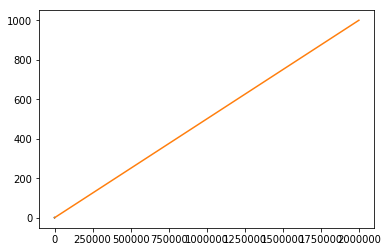

In [22]:
plt.plot(x,y,t)

In [19]:
%%time
#Main Code: Signal Tracking using single RNN
with tf.Session() as sess:
    mode_list=[]
    loss_list=np.zeros(3)
    sess.run(tf.global_variables_initializer())#initiliazes all global variables
    x,y,t=generate_data()#generates signal
    _current_state=np.zeros((num_of_layers,2,1,state_size))
    data_length=len(x)/truncated_bp_length#in terms of vectors of length truncated bp length
    frame_id=0#time in terms of vectors of length truncated_bp_length
    tracking_err_threshold=0.0001#if the error is less than this threshold- tracking continues without training
                               #else training will start
    trainining_err_threshold=0.5*tracking_err_threshold#training stopping criteria
    err_threshold=tracking_err_threshold#initial training decision threshold is set to tracking error threshold
    while(frame_id<data_length):#run up to end of the signal
        #take batches of data
        batchX=np.asarray([x[frame_id*truncated_bp_length:(frame_id+1)*truncated_bp_length]])
        batchY=np.asarray([y[frame_id*truncated_bp_length:(frame_id+1)*truncated_bp_length]])
        batchT=t[frame_id*truncated_bp_length:(frame_id+1)*truncated_bp_length]
        #calculates prediction error
        _error=sess.run(error,
                        feed_dict={
                            input_x:batchX,
                            output_y:batchY,
                            init_state:_current_state
                        }
                       )
        #if it is greater than tracking threshold training is deviced
        #and threshold is updated with the training threshold
        if _error>err_threshold:
            [_error,_train_step,_current_state,_predictions_series]=sess.run(
                [error,train_step,current_state,predictions_series],
                feed_dict={
                    input_x:batchX,
                    output_y:batchY,
                    init_state:_current_state
                }
            )
            err_threshold=trainining_err_threshold
            k=2
        else:
        #when training finishes, tracking starts
        #and threshold is updated with the tracking threshold
        #
            [_error,_current_state,_predictions_series]=sess.run(
                [error,current_state,predictions_series],
                feed_dict={
                    input_x:batchX,
                    output_y:batchY,
                    init_state:_current_state
                }
            )
            err_threshold=tracking_err_threshold
            k=1
            
        loss_list=np.roll(loss_list,1)
        loss_list[0]=_error
        
        frame_id+=1# new frame
        mode_list.append(k)
        #plots
        if frame_id%50==0:
            print(frame_id,loss_list)

50 [0.02541561 0.02459405 0.02745377]
100 [0.00060197 0.00056895 0.00062718]
150 [0.00018206 0.00019613 0.00015275]
200 [9.52330665e-05 1.14703689e-04 1.19189543e-04]
250 [8.20130808e-05 8.57562191e-05 6.87124048e-05]
300 [5.13081977e-05 5.57693238e-05 6.13098455e-05]
350 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
400 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
450 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
500 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
550 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
600 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
650 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
700 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
750 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
800 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
850 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
900 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
950 [5.79906227e-05 5.90330528e-05 4.92100953e-05]
1000 [4.92100953e-05 5.23785711e-05 5.79906227e-05]
1050 [5.79906227

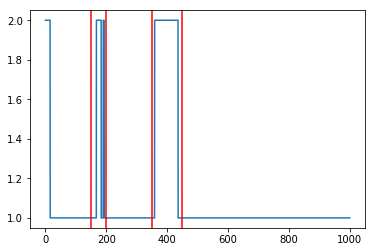

In [23]:
plt.figure()
t_frame=np.arange(0,data_length*truncated_bp_length/2000,truncated_bp_length/2000)
plt.plot(t_frame,mode_list)
plt.axvline(x=150,color='r')
plt.axvline(x=200,color='r')
plt.axvline(x=350,color='r')
plt.axvline(x=450,color='r')
plt.show()